In [1]:
%load_ext autoreload
%autoreload 2

In [103]:
from __future__ import annotations
from dataclasses import dataclass, field, replace
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any

In [101]:
from RaTag.datatypes import Run # type: ignore
import RaTag.dataIO as dataIO # type: ignore
import RaTag.config as config # type: ignore
import RaTag.transport as transport # type: ignore
import RaTag.plotting as plotting # type: ignore
import RaTag.transformations as transf # type: ignore
import RaTag.constructors as constructors # type: ignore
import RaTag.analysis as analysis # type: ignore
import RaTag.cuts as cuts # type: ignore
# import RaTag.measurements as meas

In [ ]:
def prepare_set(s: SetPmt, run: Run) -> SetPmt:
    s1 = constructors.estimate_s1_from_batches(s, n_batches=5, batch_size=20)
    s1 = constructors.set_fields(s1, drift_gap_cm=run.drift_gap, el_gap_cm=run.el_gap, gas_density=run.gas_density)
    s1 = constructors.set_transport_properties(s1, drift_gap_cm=run.drift_gap, transport=None)
    return s1

# Define RUN5

In [6]:
base_dir = Path('/Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec')
meas_path = base_dir / 'FieldScan_5GSsec_Anode2000V_Gate100V'
wfm_paths = sorted(meas_path.glob('*.wfm'))

In [166]:
run5 = Run(
    root_directory = base_dir,
    run_id = "RUN5",
    el_field = 2375,            # V/cm
    target_isotope = "Th228",
    pressure = 2.0,             # bar
    temperature = 297,          # K
    sampling_rate = 5e9,
    el_gap = 0.8,               # cm
    drift_gap = 1.4,            # cm

    width_s2 = 5.6                # µs 
)

run5 = constructors.populate_run(run5)
run5 = transport.with_gas_density(run5)

run5.gas_density

4.877421222922505e+19

# S2 area pipeline

## Test in single waveform

<Axes: title={'center': 'RUN5_26052025_Gate100_Anode2000_P6_1002Wfm.wfm'}, xlabel='Time (µs)', ylabel='Signal (V)'>

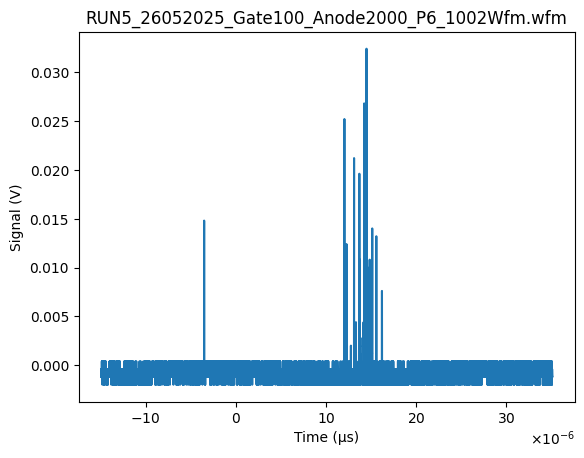

In [53]:
wf = dataIO.load_wfm(str(wfm_paths[3]))
wf.plot()

In [66]:
transf.s2_area_pipeline(wf, t_window = (11.17, 16.17), threshold=0.4, dt = 2e-4)

np.float64(1.321589693542793)

## Test with single set

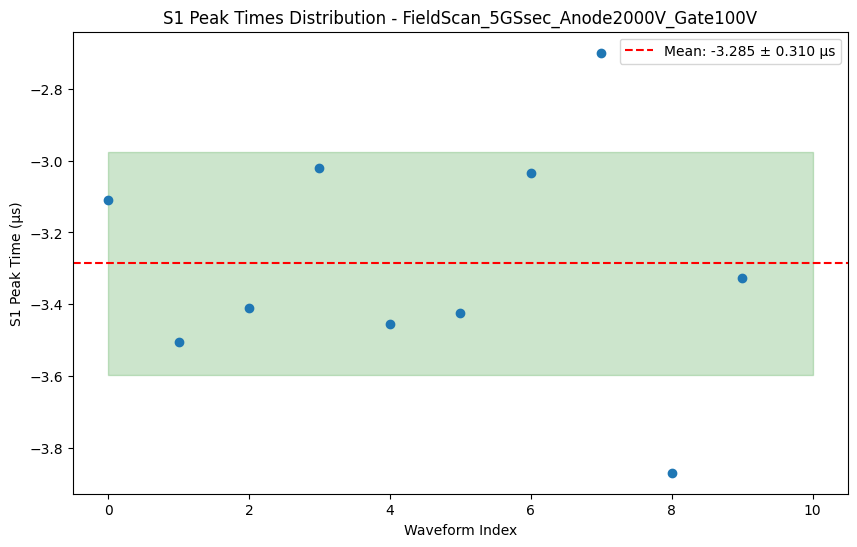

In [200]:
set100 = constructors.set_from_dir(meas_path)

set100 = constructors.set_fields(set100, run5.drift_gap, run5.el_gap, run5.gas_density)
set100 = constructors.set_transport_properties(set100, run5.drift_gap )
set100 = constructors.estimate_s1_from_batches(set100, n_batches=10, batch_size=20, flag_plot=True)

In [79]:
set100.filenames[:3]
set100.metadata['anode'], set100.metadata['gate'], set100.metadata.get('gate')
set100.speed_drift, set100.time_drift, set100.metadata['t_s1']

(np.float64(0.924852548478617),
 np.float64(15.137548167034852),
 np.float64(-3.299))

In [85]:
transf.s2_area_pipeline(dataIO.load_wfm(set100.source_dir / set100.filenames[3]), t_window = (11.17, 16.17), threshold=0.8, dt = 2e-4)

mean wf after threshold_clip: 0.29077654952015536


np.float64(1.453940902910681)

In [87]:
areas_100 = analysis.integrate_set_s2(set100, t_window=(11.17, 18.17), n_pedestal=2000, threshold=0.8, dt=2e-4)

S2Areas(source_dir=FieldScan_5GSsec_Anode2000V_Gate100V, n_areas=10000, method=s2_area_pipeline)

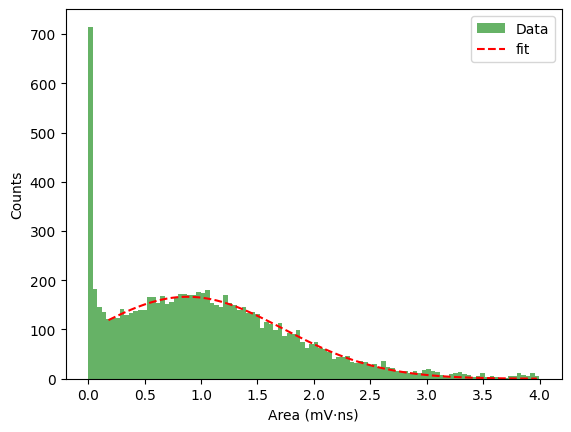

In [93]:
fitted_100 = analysis.fit_set_s2(areas_100, bin_cuts=(0, 4), nbins=100, exclude_index=4, flag_plot=True)
fitted_100

<Axes: title={'center': 'S2 Area Histogram for Set FieldScan_5GSsec_Anode2000V_Gate100V'}, xlabel='S2 Area (mV·µs)', ylabel='Counts'>

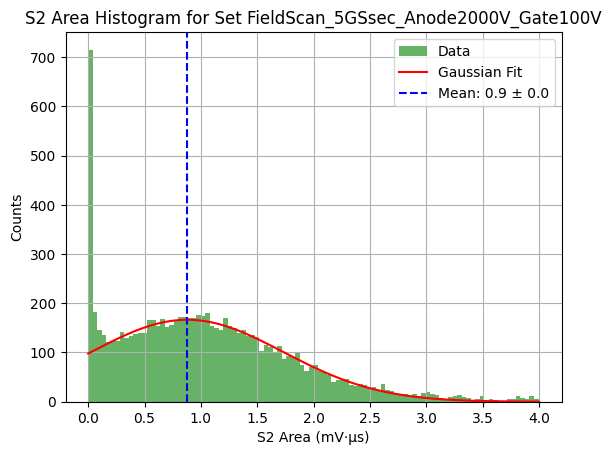

In [94]:
plotting.plot_hist_fit(fitted_100, nbins=100, bin_cuts=(0, 4))

# Run analysis

In [121]:
run5.sets[0].metadata

{'sampling_rate': 5000000000.0, 'anode': 2100, 'gate': 200}

In [176]:
run5 = replace(run5, sets=[prepare_set(s, run5) for s in run5.sets])

In [115]:
configs2 = config.IntegrationConfig()
configs2

IntegrationConfig(n_pedestal=2000, ma_window=9, threshold=0.8, dt=0.0002)

In [123]:
run5.width_s2

5.6

In [125]:
results_run5 = analysis.integrate_run_s2(run5, config=configs2)

Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V with t_window: (np.float64(12.37680081794834), np.float64(17.976800817948337))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V with t_window: (np.float64(17.0115956679796), np.float64(22.6115956679796))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V with t_window: (np.float64(14.538548167034854), np.float64(20.138548167034855))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V with t_window: (np.float64(8.181983189132922), np.float64(13.781983189132921))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3500V_Gate1600V with t_window: (np.float64(7.08

In [22]:
results_run5['FieldScan_5GSsec_Anode1950V_Gate50V']

S2Areas(set_id=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline)

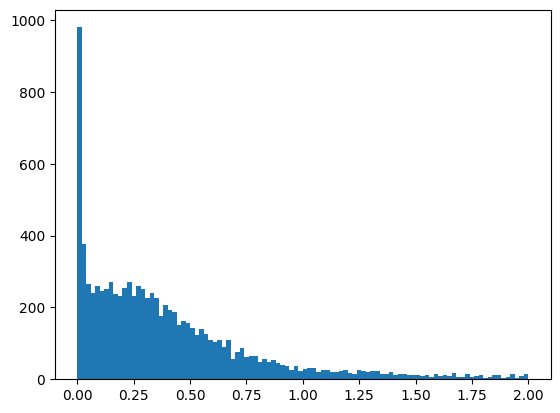

In [126]:
areas100 = results_run5['FieldScan_5GSsec_Anode2000V_Gate100V'].areas
areas100_cut = areas100[areas100 < 2]
plt.hist(areas100_cut, bins=100, histtype='stepfilled');

In [61]:
results_run5

{'FieldScan_5GSsec_Anode1950V_Gate50V': S2Areas(set_id=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2000V_Gate100V': S2Areas(set_id=FieldScan_5GSsec_Anode2000V_Gate100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2100V_Gate200V': S2Areas(set_id=FieldScan_5GSsec_Anode2100V_Gate200V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2500V_Gate600V': S2Areas(set_id=FieldScan_5GSsec_Anode2500V_Gate600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3000V_Gate1100V': S2Areas(set_id=FieldScan_5GSsec_Anode3000V_Gate1100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3500V_Gate1600V': S2Areas(set_id=FieldScan_5GSsec_Anode3500V_Gate1600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode4000V_Gate2100V': S2Areas(set_id=FieldScan_5GSsec_Anode4000V_Gate2100V, n_areas=10001, method=s2_area_pipeline)}

In [127]:
fitted = analysis.fit_run_s2(results_run5, config=config.FitConfig())
fitted

{'FieldScan_5GSsec_Anode2100V_Gate200V': S2Areas(source_dir=FieldScan_5GSsec_Anode2100V_Gate200V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode1950V_Gate50V': S2Areas(source_dir=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2000V_Gate100V': S2Areas(source_dir=FieldScan_5GSsec_Anode2000V_Gate100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2500V_Gate600V': S2Areas(source_dir=FieldScan_5GSsec_Anode2500V_Gate600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3500V_Gate1600V': S2Areas(source_dir=FieldScan_5GSsec_Anode3500V_Gate1600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3000V_Gate1100V': S2Areas(source_dir=FieldScan_5GSsec_Anode3000V_Gate1100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode4000V_Gate2100V': S2Areas(source_dir=FieldScan_5GSsec_Anode4000V_Gate2100V, n_areas=10001, method=s2_area_pipeline)}

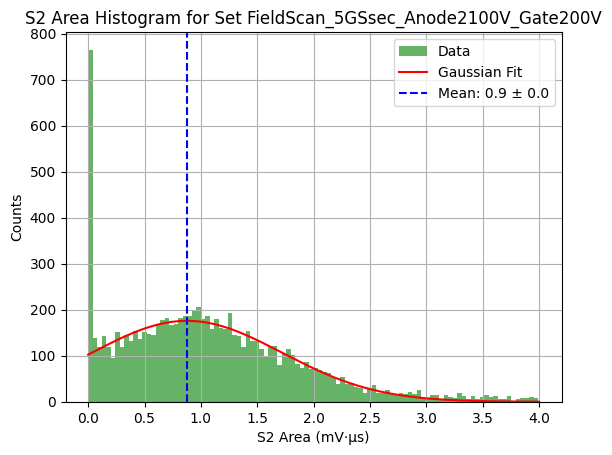

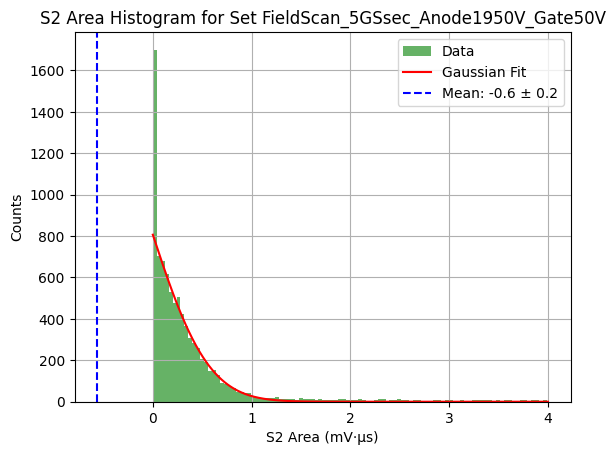

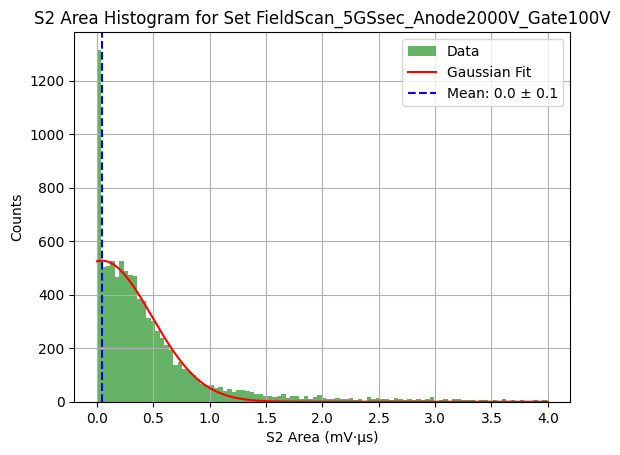

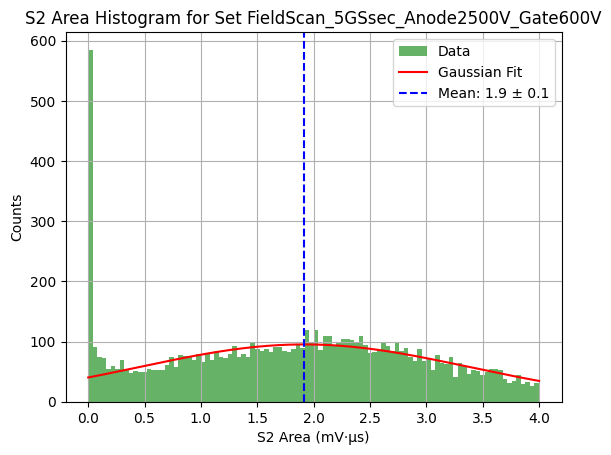

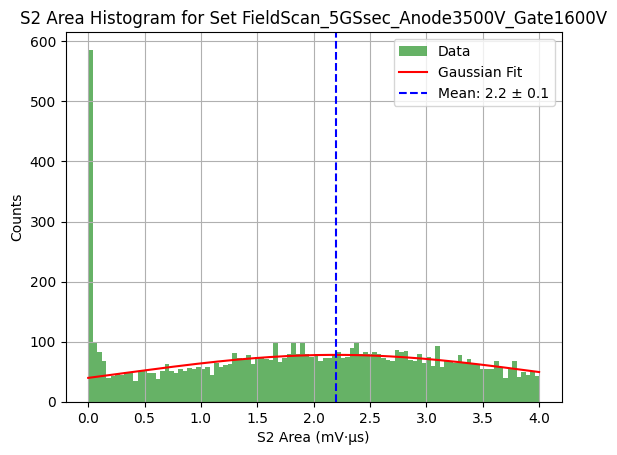

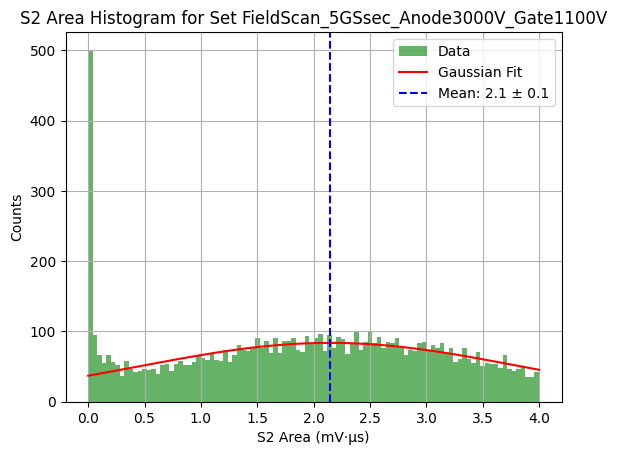

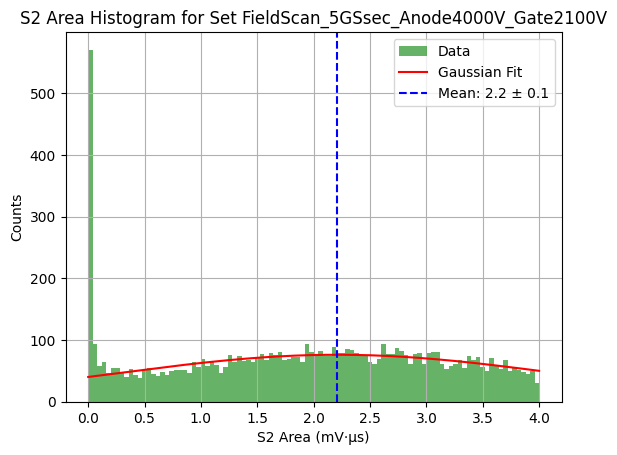

In [128]:
for set_id, fit in fitted.items():
    plotting.plot_hist_fit(fit, nbins=100, bin_cuts=(0, 4));

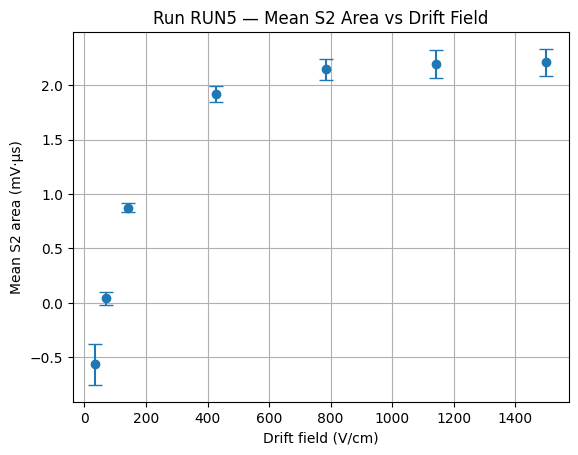

In [129]:
plotting.plot_s2_vs_drift(run5, fitted, )

# Analysis RUN5 with width_s2 = 20 µs

S2 width covering the waveforms at lowest field

In [273]:
run5 = replace(run5, width_s2 = 20)

In [275]:
results_run52 = analysis.integrate_run_s2(run5, ts2_tol=-2.7, config=config.IntegrationConfig())

Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V with t_window: (np.float64(11.611595667979596), np.float64(31.611595667979596))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V with t_window: (np.float64(9.138548167034852), np.float64(29.138548167034852))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2100V_Gate200V with t_window: (np.float64(6.976800817948338), np.float64(26.976800817948337))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2500V_Gate600V with t_window: (np.float64(2.7819831891329203), np.float64(22.78198318913292))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode3000V_Gate1100V with t_window: (np.float64(1

In [279]:
config2 = config.FitConfig(
    nbins=100,
    bin_cuts=(0, 6),
    exclude_index=2,
)

In [281]:
fitted2 = analysis.fit_run_s2(results_run52, config=config2)
fitted2

{'FieldScan_5GSsec_Anode1950V_Gate50V': S2Areas(source_dir=FieldScan_5GSsec_Anode1950V_Gate50V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2000V_Gate100V': S2Areas(source_dir=FieldScan_5GSsec_Anode2000V_Gate100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2100V_Gate200V': S2Areas(source_dir=FieldScan_5GSsec_Anode2100V_Gate200V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode2500V_Gate600V': S2Areas(source_dir=FieldScan_5GSsec_Anode2500V_Gate600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3000V_Gate1100V': S2Areas(source_dir=FieldScan_5GSsec_Anode3000V_Gate1100V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode3500V_Gate1600V': S2Areas(source_dir=FieldScan_5GSsec_Anode3500V_Gate1600V, n_areas=10000, method=s2_area_pipeline),
 'FieldScan_5GSsec_Anode4000V_Gate2100V': S2Areas(source_dir=FieldScan_5GSsec_Anode4000V_Gate2100V, n_areas=10001, method=s2_area_pipeline)}

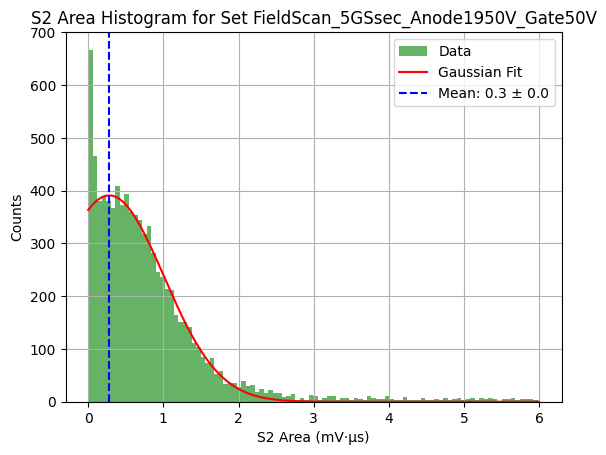

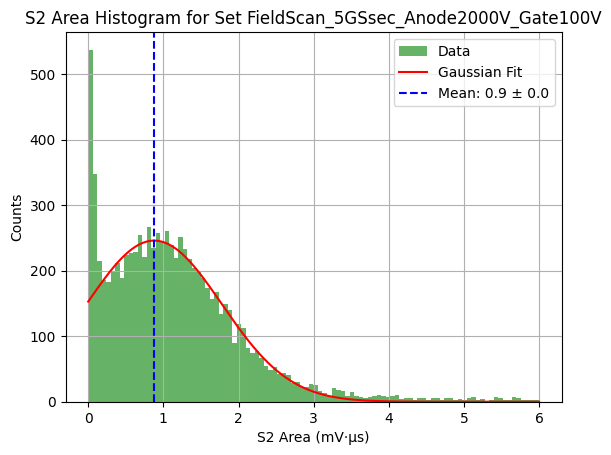

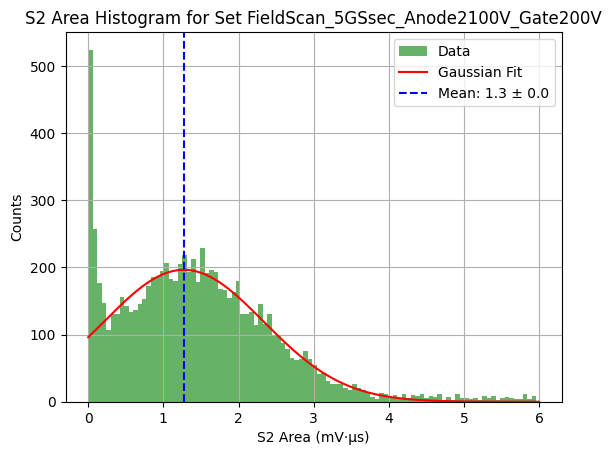

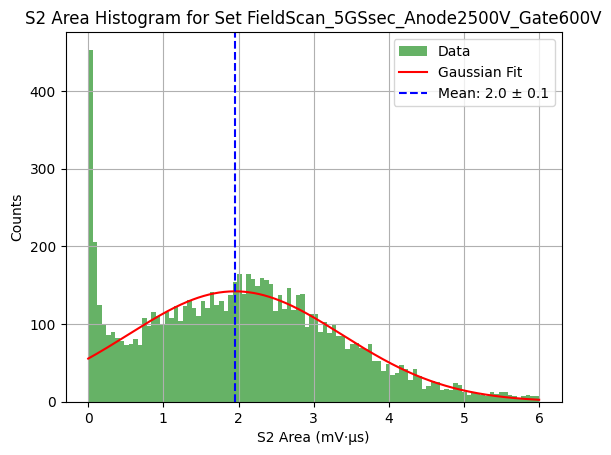

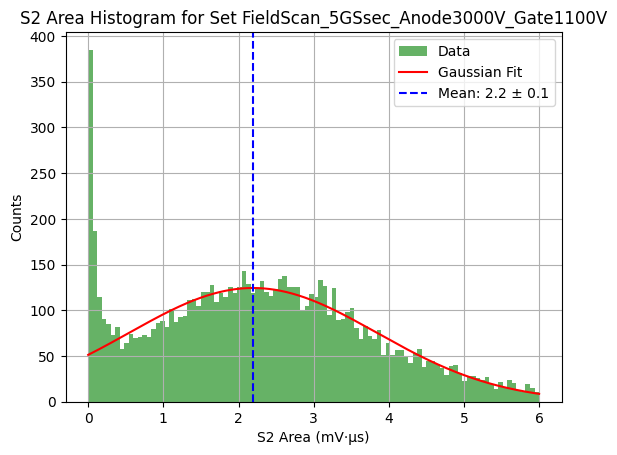

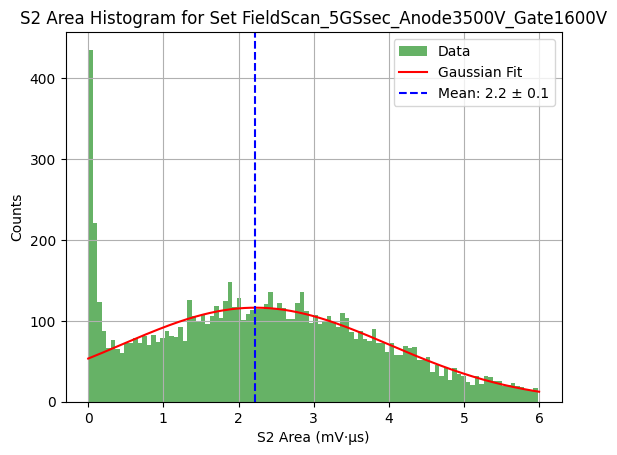

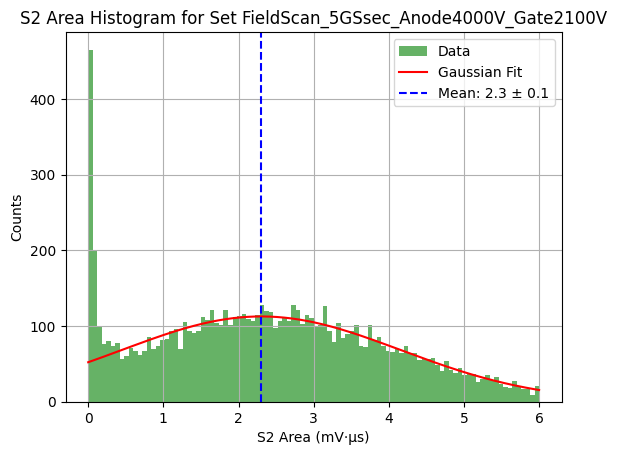

In [282]:
for set_id, fit in sorted(fitted2.items()):
    plotting.plot_hist_fit(fit, nbins=100, bin_cuts=(0, 6));

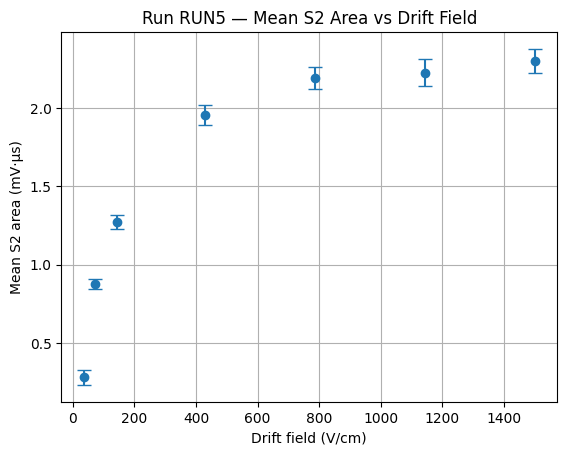

In [283]:
plotting.plot_s2_vs_drift(run5, fitted2, )

## Optimize width_S2 to obtain proper values

In [177]:
run52 = replace(run5, sets=run5.sets[:2])

In [184]:
s2_widths = np.arange(5.6, 23, 3)
results_run52 = {}
for w in s2_widths:
    print(f"Processing width_s2 = {w} µs")
    run52 = replace(run52, width_s2 = w)
    results_run52[w] = analysis.integrate_run_s2(run52, config=configs2)

Processing width_s2 = 5.6 µs
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V with t_window: (np.float64(17.0115956679796), np.float64(22.6115956679796))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V with t_window: (np.float64(14.538548167034854), np.float64(20.138548167034855))
Processing width_s2 = 8.6 µs
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode1950V_Gate50V with t_window: (np.float64(17.0115956679796), np.float64(25.6115956679796))
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_EL2375Vcm_5GSsec/FieldScan_5GSsec_Anode2000V_Gate100V with t_window: (np.float64(14.538548167034854), np.float64(23.138548167034855))
Processing width_s2 = 11.6 µs
Processing set /Users/pabloherrero/sabat/RaTagging/scope_data/waveforms/RUN5_E

In [188]:
exclude_indices.get(5.6)

[1]

Fitted width_s2 = 5.6 µs
Fitted width_s2 = 8.6 µs
Fitted width_s2 = 11.6 µs
Fitted width_s2 = 14.6 µs
Fitted width_s2 = 17.6 µs
Fitted width_s2 = 20.6 µs


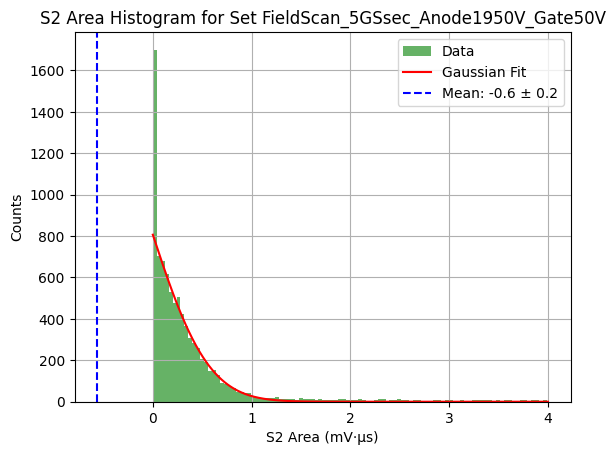

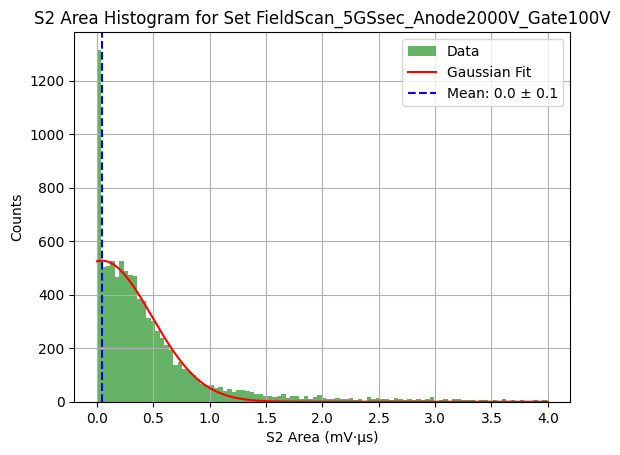

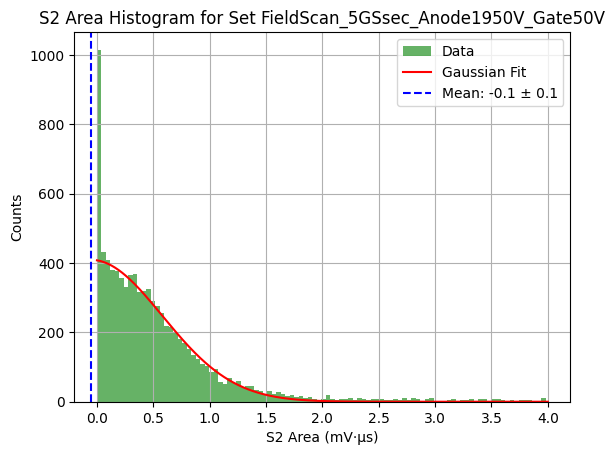

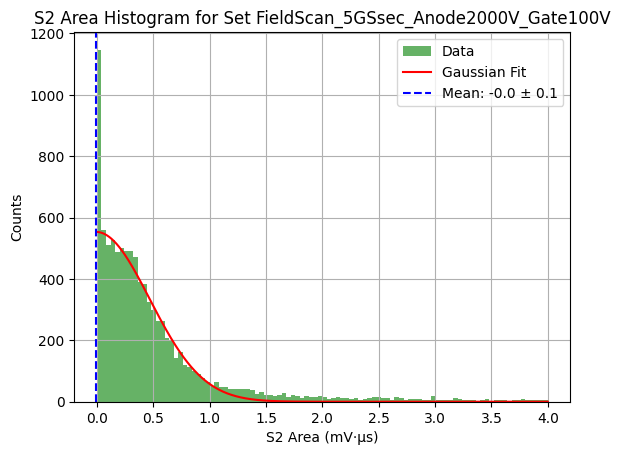

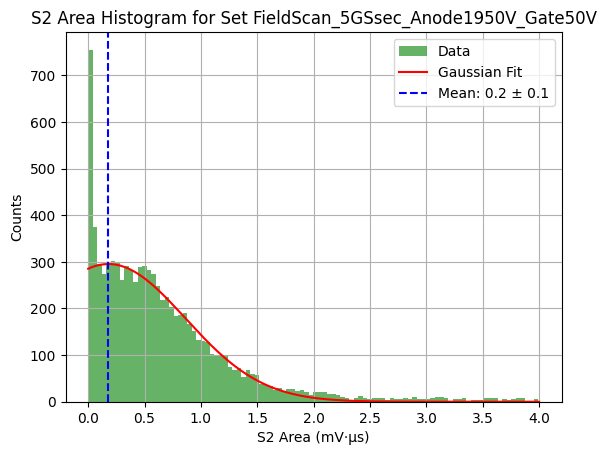

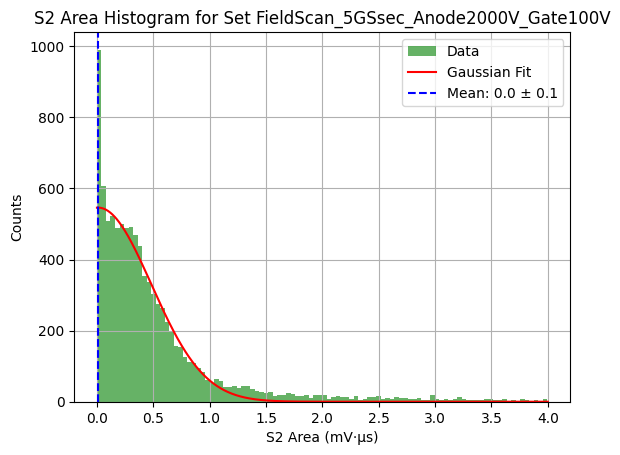

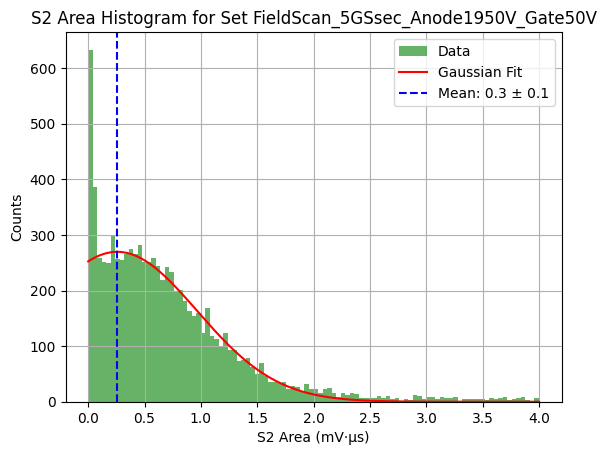

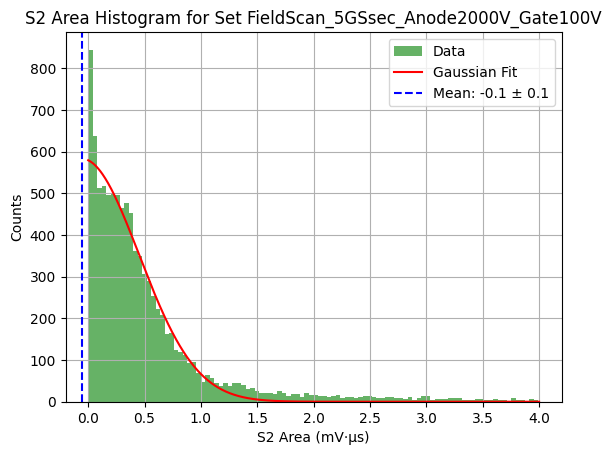

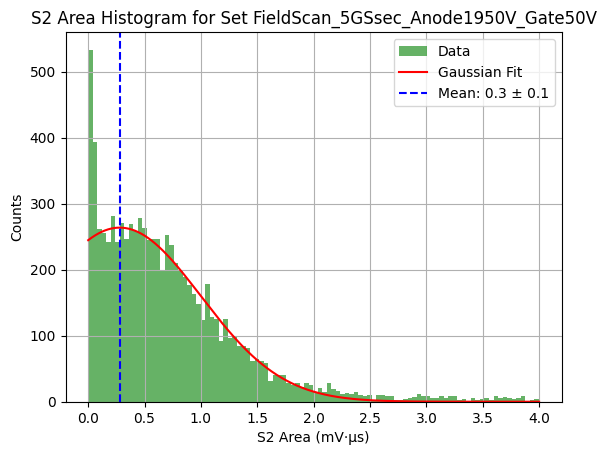

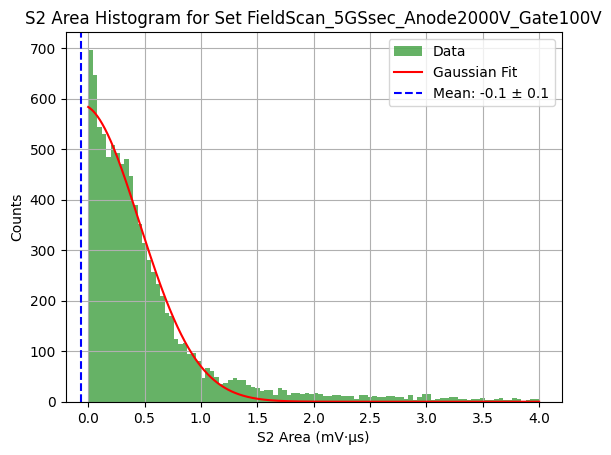

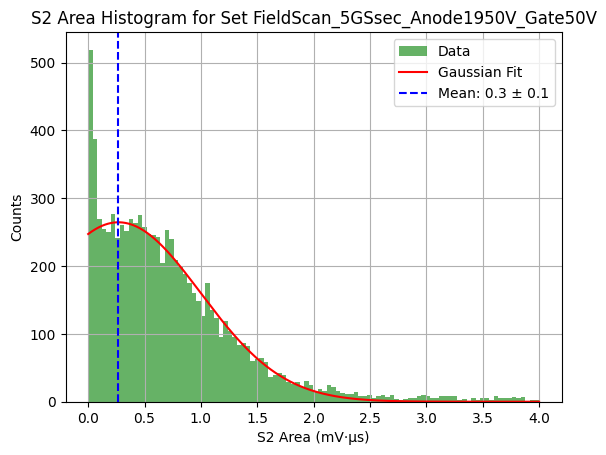

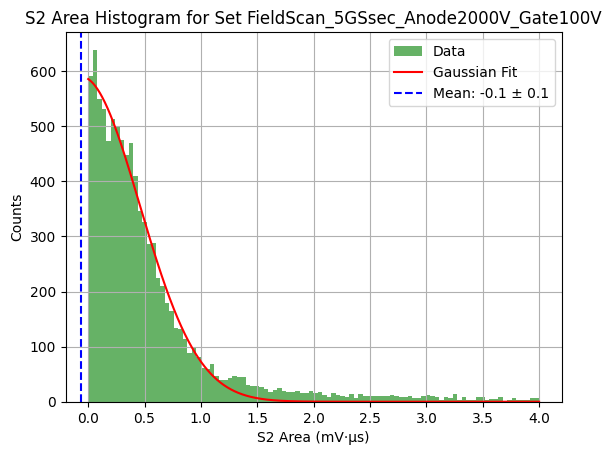

In [189]:
fitted_s2s = {}
exclude_indices = {
    5.6: 1,
    8.6: 2,
    11.6: 2,
    14.6: 3,
    17.6: 3,
    20.6: 4,
}

for i, (width, res) in enumerate(results_run52.items()):

    fitted_s2s[width] = analysis.fit_run_s2(res, config=config.FitConfig(
        nbins=100,
        bin_cuts=(0, 4),
        exclude_index=exclude_indices.get(width, []),
    ))
    print(f"Fitted width_s2 = {width} µs")
    for set_id, fit in sorted(fitted_s2s[width].items()):
        plotting.plot_hist_fit(fit, nbins=100, bin_cuts=(0, 4));

# New Plotters

In [212]:
Path(wf.source).name

'RUN5_26052025_Gate100_Anode2000_P6_1002Wfm.wfm'

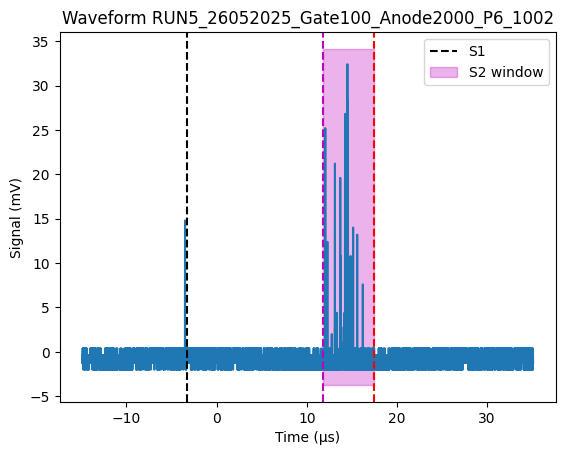

In [ ]:
plotting.plot_winS2_wf(wf, t_s1=set100.metadata['t_s1'], time_drift=set100.time_drift, width_s2=run5.width_s2, ts2_tol=0)

In [235]:
set100.metadata.get("t_s1")

np.float64(-3.285)

In [284]:
run5.width_s2

20

In [257]:
plotting.scroll_winS2(set100, width_s2=run5.width_s2, ts2_tol=0)

IntSlider(value=0, description='Waveform:', max=9999)

Output()

In [272]:
plotting.plot_run_winS2(run52, ts2_tol=-2.7, scroll=True)

IntSlider(value=0, description='Waveform:', max=9999)

Output()

IntSlider(value=0, description='Waveform:', max=9999)

Output()

(None, [])